In [29]:
# Frquent
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# ML
import sklearn
#import xgboost as xgb

In [30]:
# Load in the train and test datasets
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [31]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [32]:
X = train.drop('Survived',axis=1)
y = train['Survived'] 
df = pd.concat([X,test])

In [33]:
import re
def matchstring(pattern,inString):
    str_search = re.search(pattern,inString)
    if str_search:
        stringmatch = str_search.group(1)
        return stringmatch
    else:
        return 'nomatch'

In [34]:

df['title'] = df['Name'].apply(lambda x: matchstring(r'\w+, (\w+\.)',x))

df.loc[df['title'].isin(['Mlle.','Ms.']),'title'] = 'Miss.'
df.loc[df['title'].isin(['Mme.']),'title'] = 'Mrs.'
df.loc[~df['title'].isin(['Miss.','Mrs.','Mr.','Master.']),'title'] ='rare'

df['companion'] = df['SibSp'] + df['Parch']
df['one'] = (df['companion']==0)*1

df['Cabin_m'] = df['Cabin'].isnull()*1
df['Cabin_f'] = df['Cabin'].fillna('0').apply(lambda x: x[0])
df['Cabin_ct'] = df['Cabin'].fillna('0').apply(lambda x:len(x.split(' ')) )


df['Ticket'] = df['Ticket'].apply(lambda x: matchstring(r'(\b[\d]+)$',x))
ticketdict =  dict(df['Ticket'].value_counts())
df['Ticket_ct'] =df['Ticket'].apply(lambda x: ticketdict[x])

df['Embarked'] = df['Embarked'].fillna((df['Embarked']).mode()[0])

df['Age_m'] = df['Age'].isnull()*1
fillage = df.loc[df['title']=='Master.','Age']
df.loc[df['title']=='Master.','Age'] = fillage.fillna(fillage.median())
fillage = df.loc[df['title']=='Dr.','Age']
df.loc[df['title']=='Dr.','Age'] = fillage.fillna(fillage.median())
fillage = df.loc[df['Sex']=='female','Age']
df.loc[df['Sex']=='female','Age'] = fillage.fillna(fillage.median())
fillage = df.loc[df['Sex']=='male','Age']
df.loc[df['Sex']=='male','Age'] = fillage.fillna(fillage.median())

df['Fare'] = df['Fare'].fillna(df['Fare'].median)

In [36]:
df.drop(['Cabin','Name','PassengerId','Ticket'],axis=1,inplace=True)

In [37]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.stats import skew
# select
class CateSelector(BaseEstimator,TransformerMixin):
    def __init__(self):
        '''Select attributes in the attribute_names list'''
        None
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.select_dtypes(include=['object'])
    
class NumSelector(BaseEstimator,TransformerMixin):
    def __init__(self):
        '''Select attributes in the attribute_names list'''
        None
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.select_dtypes(exclude=['object'])
class SkewTransform(BaseEstimator,TransformerMixin):
    def __init__(self,trans = True):
        '''Transform attributes with high skewness using log transform'''
        self.trans = trans
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        if self.trans:
            skewed_feats = X.apply(lambda x: skew(x.dropna())) #compute skewness
            skewed_feats = skewed_feats[skewed_feats > 0.75]
            skewed_feats = skewed_feats.index
            X[skewed_feats] = np.log1p(X[skewed_feats])
        return X

class CateEncode(BaseEstimator, TransformerMixin):
    def __init__(self,trans = True, entype = 'num'):
        self.trans = trans
        self.entype = entype
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        #X_cate_=X.select_dtypes(include=['object'])
        if self.trans:
            if self.entype=='num':
                encode = LabelEncoder()
                X = X.apply(lambda r:encode.fit_transform(r))
            elif self.entype == 'hot':
                X = pd.get_dummies(X)
            elif self.entype == 'bin':
                X = pd.concat([BinaryEncodeSeries(X[col]) for col in X.columns],axis=1)
        return X

class Norm(BaseEstimator, TransformerMixin):
    def __init__(self,trans = True, normtype = 'std'):
        self.trans = trans
        self.normtype = normtype
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        if self.trans:
            if self.normtype == 'std':
                normlizer = StandardScaler()
                X = normlizer.fit_transform(X)
            elif self.normtype == 'minmax':
                normlizer = MinMaxScaler()
                X = normlizer.fit_transform(X)
        return X



In [38]:
from sklearn.preprocessing import Imputer,StandardScaler,RobustScaler
from sklearn.pipeline import Pipeline, FeatureUnion,make_pipeline
fullpipe = Pipeline([
            #('customtrans',CustomTrans(True)),
            #('outlier',RemoveOutlier()),
            #('CateOrdi',CateOrdinal(True)),
            ('transform', FeatureUnion([
                ('num_trans', Pipeline([('selector',NumSelector()),('trans',SkewTransform(True)),('norm', Norm(True,'minmax'))])),
                ('cate_trans', Pipeline([('selector',CateSelector()),('encode',CateEncode('hot'))]))
                        ])),
            #('norm', Norm(False))
        ])
df_trans = fullpipe.fit_transform(df)

In [39]:
Xed = df_trans[:train.shape[0]]
X_test = df_trans[train.shape[0]:]


(418L, 15L)

In [65]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import cross_val_score, GridSearchCV
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
#import xgboost as xgb

param_grids = {
        'LSVC': {
            'C': hp.loguniform('C', 0, 20),
            'loss':['hinge','squared_hinge'],
            #'dual':[False]
        },
    
        'RBFSVM':{
            'C': hp.loguniform('C', 0, 20),
            'gamma': hp.uniform('gamma', 0, 20)
        },
    
        'PolySVM':{
            'C': hp.loguniform('C', 0, 20),
            'degree':hp.choice('degree',range(2,8)),
            'coef0':hp.uniform('coef0',0,5)
        },
    
        'DT' : {
            'max_depth':hp.choice('max_depth',[2,4,8,12,None]),
            'max_features':hp.choice('max_features',['sqrt',None]),
            'criterion': hp.choice('criterion', ["gini", "entropy"])
        },
    
        'RFC':{
            'n_estimators': hp.choice('n_estimators',[500]),
            'max_depth':hp.choice('max_depth',[2,4,8,12,None]),
            'max_features':hp.choice('max_features',['sqrt',None]),
            'criterion': hp.choice('criterion', ["gini", "entropy"])
        },
    
        'GBC':{
            'n_estimators':hp.choice('n_estimators',[500]),
            'learning_rate':hp.choice('learning_rate',[0.05]),
            'max_depth':hp.choice('max_depth',[2,4,8,12,None]),
            'max_features':hp.choice('max_features',['sqrt',None]),
            'loss':hp.choice('loss',['ls','huber'])
        },
        'ADAC':{
                'n_estimators':hp.choice('n_estimators',[500]),
                'learning_rate':hp.choice('learning_rate',[0.01,0.05,0.1]),
            },
        
        'KNN': {
            'n_neighbors': hp.choice('n_neighbors', range(1,20))
        },
    
        #'NB' : {'alpha': hp.uniform('alpha', 0.0, 2.0)}
        }

models = {
    'LSVC': LinearSVC(),
    'RBFSVM':SVC(kernel = 'RBF'),
    'PolySVM':SVC(kernel = 'Poly'),
    'DT':DecisionTreeClassifier(),
    'RFC':RandomForestClassifier(),
    'GBC':GradientBoostingClassifier(),
    'ADAC':AdaBoostClassifier(),
    'KNN': NearestNeighbors(),
    #'NB': GaussianNB(),
    }

ImportError: No module named hyperopt

In [82]:
model = SVC(kernel='poly',degree= 3)

In [ ]:
model = GradientBoostingClassifier(n_estimators=500,max_features=10,max_depth=6)

In [ ]:

scores = cross_val_score(model,Xed, y,cv=10 )
print 'performance {} ({})'.format(scores.mean(), scores.std())

In [79]:
Xed.shape

(891L, 15L)

In [70]:
model.fit(Xed,y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=500, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [66]:
print 'performance {} ({})'.format(scores.mean(), scores.std())

performance 0.829497219385 (0.0475043084306)


In [76]:
dfout = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived':model.predict(X_test)})
dfout.to_csv('submission.csv',index=False)

In [74]:
dfout

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,0
7,899,0
8,900,1
9,901,0


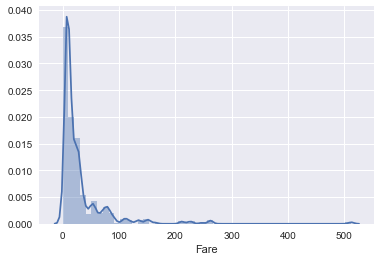

In [202]:
sns.distplot(train['Fare'].dropna())

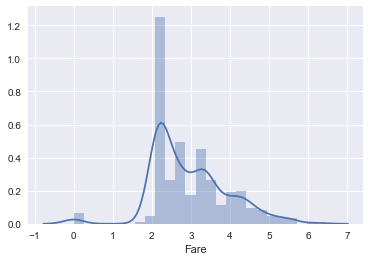

In [203]:
sns.distplot(np.log1p(train['Fare']))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


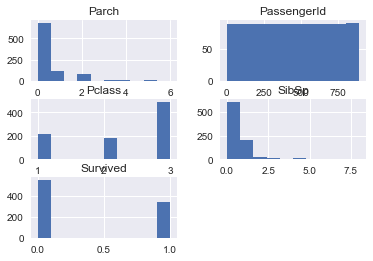

In [48]:
def exp_int_dist (train):
    flt_cols = train[train.dtypes[train.dtypes =='int64'].index]
    fig,ax = plt.subplots()
    flt_cols.hist(ax=ax)
    fig.savefig('Summary_Dataexplore_col_int_dist.pdf')
exp_int_point(train)

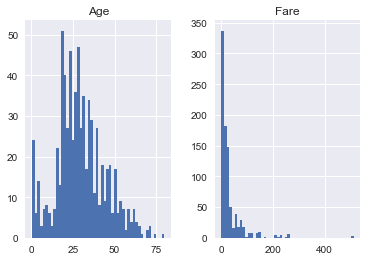

In [50]:
def exp_float_dist (train):
    flt_cols = train[train.dtypes[train.dtypes == 'float'].index]
    fig,ax = plt.subplots()
    flt_cols.hist(bins=50,ax=ax)
    fig.savefig('Summary_Dataexplore_col_float_dist.pdf')
exp_float_dist (train)

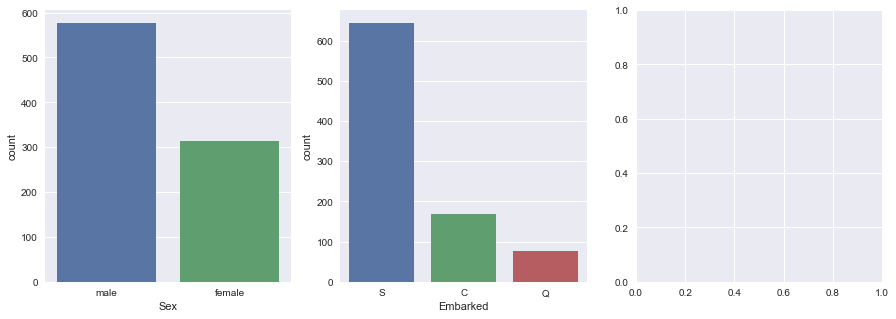

In [60]:
def exp_cate (train):
    cate= train[train.dtypes[train.dtypes == 'object'].index]
    a = cate.isnull().sum()
    b = cate.apply(lambda x:( x.value_counts()>0).sum())
    cate_sum=pd.concat([a,b],axis=1)
    cate_sum.columns=['miss_ct','unq_ct']
    cate_toplot_cols = train[cate_sum['unq_ct'][(cate_sum['unq_ct']<10)].index]
    shapedf = cate_toplot_cols.shape
    nbcol = shapedf[1]
    nbrow = shapedf[0]
    width = 3
    if nbcol < width:
        fig,ax = plt.subplots(1,width,figsize=(5*width,5*(nbcol/3+1)))
        for i,col in enumerate(list(cate_toplot_cols.columns.values)):
            sns.countplot(train[col].dropna(),ax=ax[i%width]) 
    else:
        fig,ax = plt.subplots(nbcol/width+1,width,figsize=(5*(nbcol/3+1),5))
        for i,col in enumerate(list(cate_toplot_cols.columns.values)):
            sns.distplot(train[col].dropna(),ax=ax[i/width,i%width]) 
    fig.savefig('Summary_Dataexplore_col_cate_dist.pdf')
    return cate_sum
cate_sum = exp_cate (train)

In [68]:
# outlier
# get test set
from sklearn.model_selection import ShuffleSplit
# Processing missing value dropna(), drop(), fillna()
## 1. what represent missing value 2. strategy to impute
from sklearn.preprocessing import Imputer  # strategy= 'median'/'mean'/'most_frequent'
imputer = Imputer(strategy="median") 


# handle categorical Attributes: stirng -> number, number -> onehot, string -> onehot
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer
t = train['Embarked'].dropna()
encoder = LabelBinarizer(sparse_output=True)
encoded = encoder.fit_transform(t)
encoded

# Custom Transformer
from sklearn.base import BaseEstimator, TransformerMixin

# Feature scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler


# Pipeline
from sklearn.pipeline import Pipeline, FeatureUnion 

# GridSearch
from sklearn.model_selection import GridSearchCV 

array([['S'],
       ['C'],
       ['S'],
       ['S'],
       ['S'],
       ['Q'],
       ['S'],
       ['S'],
       ['S'],
       ['C'],
       ['S'],
       ['S'],
       ['S'],
       ['S'],
       ['S'],
       ['S'],
       ['Q'],
       ['S'],
       ['S'],
       ['C'],
       ['S'],
       ['S'],
       ['Q'],
       ['S'],
       ['S'],
       ['S'],
       ['C'],
       ['S'],
       ['Q'],
       ['S'],
       ['C'],
       ['C'],
       ['Q'],
       ['S'],
       ['C'],
       ['S'],
       ['C'],
       ['S'],
       ['S'],
       ['C'],
       ['S'],
       ['S'],
       ['C'],
       ['C'],
       ['Q'],
       ['S'],
       ['Q'],
       ['Q'],
       ['C'],
       ['S'],
       ['S'],
       ['S'],
       ['C'],
       ['S'],
       ['C'],
       ['S'],
       ['S'],
       ['C'],
       ['S'],
       ['S'],
       ['C'],
       [nan],
       ['S'],
       ['S'],
       ['C'],
       ['C'],
       ['S'],
       ['S'],
       ['S'],
       ['S'],
       ['S'],
      

SyntaxError: invalid syntax (<ipython-input-78-716a863a66de>, line 1)

In [72]:
from sklearn.pipeline import Pipeline, FeatureUnion

<1x891 sparse matrix of type '<type 'numpy.float64'>'
	with 891 stored elements in Compressed Sparse Row format>